# Seattle and Boston airbnb customer review data process

This note book will describe how I process the customer review data from Seattle and Boston Airbnb.
This notebook is more like a tutorial to help myself go through a natrual language process.

In [2]:
#import necessary library

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
#import nltk
#nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
%matplotlib inline

In [2]:
seattle_reviews=pd.read_csv("seattle/reviews.csv")

In [5]:
seattle_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [6]:
seattle_reviews.shape

(84849, 6)

In [71]:
seattle_reviews_cleaned=seattle_reviews[seattle_reviews['comments'].isnull()==False]

In [8]:
seattle_reviews_cleaned['length']=seattle_reviews_cleaned['comments'].apply(len)

C:\Users\xhc\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


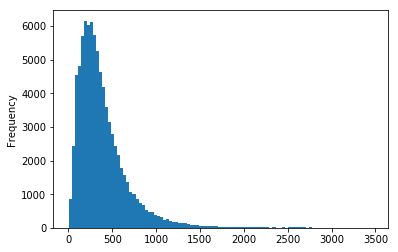

In [9]:
seattle_reviews_cleaned['length'].plot.hist(bins=100)

In [10]:
seattle_reviews_cleaned[seattle_reviews_cleaned['length']==3472]['comments'].iloc[0]

"CURLERS - this is the perfect location when you are competing at the Granite Curling Club (GCC.)  The Heller Lake Log Cabin was not only in a better location than the local hotels but was cheaper and much nicer than the places our friends stayed this weekend.  And for larger groups there is also a house for rental on the same property.  \r\n\r\nWe flew into town for a Bonspiel (curling tournament) at the Granite Curling Club and this was the perfect location.  The club had a deal with some of the local hotels but when I looked into it they were 1) much farther away and 2) more expensive.  We were able to walk to GCC, which was only about three blocks away, while everyone else had to drive back and forth between the club and their hotel.  \r\n\r\nThe cabin is so nice and in such a great location for us that it makes the decision to return for future Bonspiels an easy one.  With there also being a house for rent on the same property we will likely have our whole team stay with us next t

## remove punctuation and non-english characters

Now it is time to do some encoding on the comments
Each comments contains punctuation. I want to exlcude or remove these punctuation from comments
In addtions, the comments is a mixture of english and non-english characters. In this project, I want to deal with English comments. Therefore, texts in other language needs to be filter out.

here is an example to remove punctuation

In [72]:
# lets put the first comment to a, a will be a string
first_comment=seattle_reviews_cleaned['comments'][0]

In [73]:
first_comment

'Cute and cozy place. Perfect location to everything! '

In [12]:
#remove the punctuation in the first_comment and store into nonpunc_comment
#the nonpunc_comment will be a list of string, each alphebet will be a str in this list
# space is also included as a single element in the list
nonpunc_comment=[x for x in first_comment if x not in string.punctuation]

In [13]:
#for example
nonpunc_comment[0:10]

['C', 'u', 't', 'e', ' ', 'a', 'n', 'd', ' ', 'c']

In [14]:
# use .join to put all the string together. 
#""will be added between each element in this str list. 
#Since there is nothing in the "", all the element will combine together
nonpunc_comment="".join(nonpunc_comment)

In [15]:
nonpunc_comment

'Cute and cozy place Perfect location to everything '

example to remove non-english texts

In [59]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\xhc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


True

In [60]:
englishwords=set(nltk.corpus.words.words())

In [95]:
example_mix_sentence="我很高兴 I am so happy muy contento"

In [96]:
non_english_example=[x for x in example_mix_sentence.split() if x.lower() in englishwords or not x.isalpha()]

In [97]:
non_english_example

['I', 'am', 'so', 'happy']

## remove stop words

There are some commons words, such as they, it , has and so on that exists in the comments. 
We want to remove them. In this case, we can use nltk.corpus library's stopwords

In [16]:
import nltk

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xhc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
#remove the stopwords
#make sure to use .lower(), since comments contain captial words
clean_comment=[x for x in nonpunc_comment.split() if x.lower() not in stopwords.words("english") ]

In [19]:
#here we go
clean_comment

['Cute', 'cozy', 'place', 'Perfect', 'location', 'everything']

## pack removing punctuation and stopwords together

In [88]:
def text_clean(comments):
    """
    input: a string
    output: a clean string
    process: remove punctuation, remove stopwords
    """
    englishwords=set(nltk.corpus.words.words())
    
    nonpunc_comment=[x for x in comments if x not in string.punctuation]
    nonpunc_comment="".join(nonpunc_comment)
    clean_comment=[x for x in nonpunc_comment.split() if x.lower() in englishwords or not x.isalpha() or not stopwords.words("english") ]
    
    return clean_comment

text_clean can not work on nan value, so when apply it to a df, the column that contain text has to be nan free

In [21]:
def data_text_clean(df,columns):
    """
    input: df       dataframe
           columns  the column name that contains text string
    output: cleaned dataframe with cleaned text
            removed nan in columns with text string
            apply text_clean function to remove punctuation, stopwords
    """
    
    newdf=df[df[columns].isnull()==False]
    newdf[columns]=newdf[columns].apply(text_clean)
    return newdf

now apply the clean function to the dataframe

In [22]:
seattle_reviews_cleaned=data_text_clean(seattle_reviews,'comments')

C:\Users\xhc\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


save the cleaned data to file, since it takes a while to process the data

In [23]:
seattle_reviews_cleaned.to_csv('seattle_reviews_cleaned.csv', sep=';', index = False)

load the check point savved data

In [32]:
seattle_reviews_cleaned=pd.read_csv("seattle_reviews_cleaned.csv", sep=';')

In [37]:
seattle_reviews_cleaned["comments"]

0        ['Cute', 'cozy', 'place', 'Perfect', 'location...
1        ['Kelly', 'great', 'room', 'central', 'locatio...
2        ['spacious', 'apartment', 'great', 'neighborho...
3        ['Close', 'Seattle', 'Center', 'offer', 'balle...
4        ['Kelly', 'great', 'host', 'accommodating', 'g...
5        ['Kelly', 'great', 'place', 'great', 'looking'...
6        ['Kelly', 'great', 'nice', 'neighborhood', 'pl...
7        ['hola', 'bnb', 'erz', 'left', 'Seattle', 'sim...
8        ['Kellys', 'place', 'conveniently', 'located',...
9        ['place', 'really', 'nice', 'clean', 'importan...
10       ['place', 'really', 'nice', 'clean', 'quiet', ...
11       ['listing', 'exactly', 'described', 'Kellys', ...
12       ['welcoming', 'nicer', 'place', 'live', 'Seatt...
13       ['Great', 'location', 'great', 'price', 'great...
14       ['Staying', 'Kellys', 'easy', 'location', 'blo...
15       ['Kelly', 'amazing', 'host', 'made', 'stay', '...
16       ['Despite', 'late', 'booking', 'request', 'Rac.

## perform count vectorization

### use sklearn to perform count vectorization

In [33]:
comments_vectorizer=CountVectorizer()
vectorized_seattle_reviews=comments_vectorizer.fit_transform(seattle_reviews_cleaned['comments'])

show how mamy words are included in all vocabulary

In [39]:
len(comments_vectorizer.vocabulary_)

54034

In [17]:
# the shape shows that each index will follow by a vector, the vector contains all 54034 unqiue words that appear in comments
vectorized_seattle_reviews.shape

(84831, 54034)

In [31]:
# check the sparsit: he number of zero-valued elements divided by the total number of elements 
vectorized_seattle_reviews.nnz/(vectorized_seattle_reviews.shape[0]*vectorized_seattle_reviews.shape[1])

0.0006041856586968253

In [47]:
print(vectorized_seattle_reviews)

  (0, 11288)	1
  (0, 11752)	1
  (0, 15971)	1
  (0, 26676)	1
  (0, 33170)	1
  (0, 33837)	1
  (1, 3813)	1
  (1, 5488)	1
  (1, 7315)	1
  (1, 8430)	1
  (1, 8451)	1
  (1, 8907)	1
  (1, 16171)	1
  (1, 16936)	1
  (1, 16995)	1
  (1, 17630)	1
  (1, 17864)	1
  (1, 19334)	1
  (1, 19770)	2
  (1, 20166)	1
  (1, 21513)	1
  (1, 24755)	1
  (1, 26301)	1
  (1, 26676)	1
  (1, 27492)	1
  :	:
  (84830, 6971)	1
  (84830, 8753)	1
  (84830, 8800)	1
  (84830, 9319)	1
  (84830, 9942)	1
  (84830, 12390)	1
  (84830, 12688)	1
  (84830, 14530)	1
  (84830, 15903)	1
  (84830, 19770)	1
  (84830, 21803)	1
  (84830, 24246)	1
  (84830, 25948)	1
  (84830, 26083)	1
  (84830, 27019)	1
  (84830, 29521)	1
  (84830, 33837)	1
  (84830, 34415)	1
  (84830, 37626)	1
  (84830, 38745)	1
  (84830, 41951)	1
  (84830, 42403)	1
  (84830, 44668)	1
  (84830, 45049)	1
  (84830, 49255)	1


pack everyting together

In [ ]:
def comments_vectorization(overalldf,regionaldf,col_name="comments"):
    """
    input: 
    """
    vectorizer=CountVectorizer()
    vectorizer.fit(overalldf[col_name])
    vectorized_regionaldf=vectorizer.transform(regionaldf[col_name])
    return vectorizer,vectorized_regionaldf

### count frequency words

In [48]:
sum_comments_words=vectorized_seattle_reviews.sum(axis=0)

In [54]:
freq_comments_words=[(x, sum_comments_words[0,i]) for x,i in comments_vectorizer.vocabulary_.items()] 

In [56]:
freq_comments_words

[('cute', 3489),
 ('cozy', 7692),
 ('place', 45407),
 ('perfect', 16190),
 ('location', 28558),
 ('everything', 19720),
 ('kelly', 369),
 ('great', 60776),
 ('room', 20704),
 ('central', 1487),
 ('beautiful', 9682),
 ('building', 2943),
 ('architecture', 62),
 ('style', 442),
 ('really', 16295),
 ('like', 9993),
 ('felt', 6540),
 ('guite', 1),
 ('home', 20232),
 ('wish', 1304),
 ('spent', 1597),
 ('time', 17770),
 ('went', 3066),
 ('walk', 10618),
 ('found', 2926),
 ('seattle', 39526),
 ('center', 2349),
 ('major', 835),
 ('food', 2936),
 ('festival', 88),
 ('progress', 36),
 ('treat', 574),
 ('visited', 569),
 ('space', 13972),
 ('needle', 2220),
 ('chihuly', 135),
 ('glass', 353),
 ('exhibit', 32),
 ('pikes', 1114),
 ('market', 3671),
 ('wow', 296),
 ('thanks', 7361),
 ('stay', 51984),
 ('spacious', 4797),
 ('apartment', 25840),
 ('neighborhood', 18124),
 ('kind', 3699),
 ('didnt', 6791),
 ('get', 11327),
 ('meet', 3456),
 ('always', 3436),
 ('readily', 293),
 ('available', 4489),
 (

In [50]:
print(sum_comments_words)

[[1 1 2 ... 1 1 1]]


### reverse the process fro vector to words

now extract a single comment and see how the vectorized one looks like

In [20]:
#extrac the third comment
comments2=seattle_reviews_cleaned["comments"][2]

In [23]:
# apply the comments_vectorizer to the comments
vectorized_comments2=comments_vectorizer.transform([comments2])

In [25]:
# check what the vectorized one looks like. Each vector( 0,2830) represents a single words.
print(vectorized_comments2)

  (0, 2830)	1
  (0, 3468)	1
  (0, 3505)	2
  (0, 3824)	1
  (0, 4580)	1
  (0, 5810)	1
  (0, 7800)	1
  (0, 13002)	1
  (0, 13785)	1
  (0, 14530)	1
  (0, 17146)	1
  (0, 18120)	1
  (0, 19172)	1
  (0, 19770)	1
  (0, 23708)	1
  (0, 24755)	1
  (0, 24960)	1
  (0, 28212)	1
  (0, 30249)	1
  (0, 32614)	2
  (0, 33514)	1
  (0, 33837)	1
  (0, 34136)	1
  (0, 36084)	1
  (0, 36124)	1
  (0, 37086)	1
  (0, 40296)	1
  (0, 41342)	1
  (0, 47876)	1
  (0, 48935)	1


it seems that 3505  and 32614 appear twice, I am wondering what these two words are?

In [27]:
comments_vectorizer.get_feature_names()[3505]

'apartment'

In [28]:
comments_vectorizer.get_feature_names()[32614]

'park'

### term frequency-invserse documents frequency

tfidf is intended to reflect how important a word is to a document in a collection or corpus. The tf–idf value increases proportionally to the number of times a word appears in the document 

In [34]:
tfidf_comments_transformer=TfidfTransformer()

In [36]:
# must use vectroized text, raw text will not work
tfidf_comments_transformer.fit(vectorized_seattle_reviews)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [43]:
tfidfed_seattle_comments=tfidf_comments_transformer.transform(vectorized_seattle_reviews)

lets check a tfidfed comment looks like

In [37]:
tfidf_comments2=tfidf_comments_transformer.transform(vectorized_comments2)

In [38]:
print(tfidf_comments2)

  (0, 48935)	0.17878729327834056
  (0, 47876)	0.14776820462399365
  (0, 41342)	0.13395103799583064
  (0, 40296)	0.28738536159076855
  (0, 37086)	0.19032661741706636
  (0, 36124)	0.09926131154458202
  (0, 36084)	0.2297490959594253
  (0, 34136)	0.24503745958164794
  (0, 33837)	0.06703262833782382
  (0, 33514)	0.19592606949685035
  (0, 32614)	0.29102658328477093
  (0, 30249)	0.09032151942275463
  (0, 28212)	0.14603743651835024
  (0, 24960)	0.14332985579177782
  (0, 24755)	0.23440024002717316
  (0, 23708)	0.18315151967054372
  (0, 19770)	0.058308345347210626
  (0, 19172)	0.10842817002944863
  (0, 18120)	0.2521351543661006
  (0, 17146)	0.20058977956056
  (0, 14530)	0.09241234485536451
  (0, 13785)	0.2443120821977109
  (0, 13002)	0.12565138012207785
  (0, 7800)	0.20337281516236608
  (0, 5810)	0.23809021558716045
  (0, 4580)	0.13789449655043964
  (0, 3824)	0.10824095642052464
  (0, 3505)	0.17670069546913336
  (0, 3468)	0.1898431729064038
  (0, 2830)	0.14712095666489394


In [41]:
#check inverse document frequency by searching the words
tfidf_comments_transformer.idf_[comments_vectorizer.vocabulary_['apartment']]

2.56428731418519

In [10]:
boston_reviews=pd.read_csv("boston/reviews.csv")

In [11]:
boston_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...


In [2]:
seattle_listings=pd.read_csv("seattle/listings.csv")

In [8]:
seattle_listings[['number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']]

,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,38,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0
5,17,2015-06-11,2015-09-28,95.0,10.0,10.0,10.0,10.0,10.0,10.0
6,58,2014-01-27,2015-12-07,99.0,10.0,10.0,10.0,10.0,10.0,10.0
7,173,2013-01-03,2016-01-01,97.0,10.0,10.0,10.0,10.0,9.0,10.0
8,8,2015-06-22,2015-08-17,97.0,10.0,9.0,10.0,9.0,10.0,10.0
9,32,2014-04-27,2015-12-20,97.0,10.0,10.0,10.0,10.0,10.0,9.0


In [30]:
seattle_listings[seattle_listings['review_scores_accuracy']==2.][['number_of_reviews',
       'first_review', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']]

,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
1222,1,2015-12-06,2015-12-06,20.0,2.0,4.0,2.0,2.0,6.0,2.0
2827,1,2015-11-22,2015-11-22,80.0,2.0,6.0,8.0,8.0,10.0,10.0


In [5]:
seattle_calendar=pd.read_csv("seattle/calendar.csv")

In [6]:
seattle_calendar

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN
5,241032,2016-01-09,f,NaN
6,241032,2016-01-10,f,NaN
7,241032,2016-01-11,f,NaN
8,241032,2016-01-12,f,NaN
9,241032,2016-01-13,t,$85.00
